# Agent Chat 2.0 - Chess Example

This notebook demonstrates how to use the Agent Chat 2.0 API to create a chess simulation.

Agent Chat 2.0 proposes a new design based on [Non-deterministic Finite Automaton (NFA)](https://en.wikipedia.org/wiki/Nondeterministic_finite_automaton).
The benefits of using NFA:
1. Built-in isolation of agent memory (chat history, external states, etc.) for different conversations. This allows "private chat" between the agents without asking the developer to explicitly manage memory.
2. No inheritance: agent actions are completly visible and defined by the developer. 
3. Expressiveness: NFA is very expressive can be used to model complex conversational flows such as branching, loops, etc., that are 
currently difficult to express in Agent Chat.

## TODO

The current Agent Chat 2.0 module does not come with built-in OpenAI-powered agent. We need to discuss how to add it.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Dict, List, Optional
from flaml.autogen import oai
from flaml.autogen.agentchat2.nfa import NFA
from flaml.autogen.agentchat2.context import Context
from flaml.autogen.agentchat2.message import Message
from flaml.autogen.agentchat2.stream import ListMessageStream

In [3]:
from termcolor import colored

Defining the agent states.

In [4]:
from enum import Enum

ChessPlayerState = Enum("ChessPlayerState", ["WAITING_FOR_OPPONENT", "WAITING_FOR_VALIDATION", "TERMINATED"])
BoardAgentState = Enum("BoardAgentState", ["WAITING_FOR_PLAYER"])

Defining the context for each agent class. 
Each context is a memory snapshot associated with a particular agent state.

In [5]:
import chess

player_sys_msg_tmpl = """Your name is {name} and you are a chess player. 
You are playing against {opponent_name}. 
You are playing as {color}. 
You communicate your move using universal chess interface language.
You also chit-chat with your opponent when you communicate a move to light up the mood.
You should make sure both you and the opponent are making legal moves."""


class ChessPlayerContext(Context):
    def __init__(
        self,
        board: chess.Board,
        player: chess.Color,
        opponent: chess.Color,
        player_chat_history: List[Dict],
        llm_config: Dict[str, Any],
    ) -> None:
        self.board = board
        self.player = player
        self.opponent = opponent
        self.player_chat_history = player_chat_history
        self.llm_config = llm_config
        self.player_name = "Player White" if player == chess.WHITE else "Player Black"
        self.opponent_name = "Player White" if opponent == chess.WHITE else "Player Black"
        color = "White" if player == chess.WHITE else "Black"
        self.sys_msg = {
            "role": "system",
            "content": player_sys_msg_tmpl.format(name=self.player_name, opponent_name=self.opponent_name, color=color),
        }


board_agent_sys_msg = """You are an AI-powered chess board agent.
You translate user's natural language input into legal UCI moves.
You should only reply with a UCI move string extracted from user's input."""
board_agent_examples = [
    {
        "role": "user",
        "content": " I'm excited to make my move! I will start by moving my pawn in front of my king two squares forward. It's always good to get the pawns in action early on. Here goes: e2e4. Your move, Player Black!",
    },
    {"role": "assistant", "content": "e2e4"},
    {
        "role": "user",
        "content": "Great move! As Player Black, I will respond by moving my pawn in front of my king two squares forward as well. Here's my move: e7e5. Your move, Player White!",
    },
    {"role": "assistant", "content": "e7e5"},
]


class BoardAgentContext(Context):
    def __init__(self, board: chess.Board, examples: List[Dict], llm_config: Dict[str, Any]) -> None:
        self.board = board
        self.examples = examples
        self.sys_msg = {"role": "system", "content": board_agent_sys_msg}
        self.llm_config = llm_config

Define the message classes that will be used to formulate communication between the agents, allowing the agents to pass data among each other.

In [6]:
class ChessPlayerMessage(Message):
    def __init__(self, message: str, move: chess.Move) -> None:
        self.message = message
        self.move = move

    def __repr__(self) -> str:
        return f"ChessPlayerMessage(message={self.message}, move={self.move})"


class ValidationRequest(Message):
    def __init__(self, input: str, player: chess.Color, num_tries: int) -> None:
        self.input = input
        self.player = player
        self.num_tries = num_tries

    def __repr__(self) -> str:
        return f"ValidationRequest(input={self.input}, player={self.player}, num_tries={self.num_tries})"


class ValidationResponse(Message):
    def __init__(self, move: chess.Move, input: str, num_tries: int, error: Optional[str] = None) -> None:
        self.move = move
        self.error = error
        self.num_tries = num_tries
        self.input = input

    def __repr__(self) -> str:
        return f"ValidationResponse(move={self.move}, error={self.error}, num_tries={self.num_tries}, input={self.input})"

Define the Agent classes for the chess game. Each agent is initialized with a dictionary of starting states and associated context.
It is important to note that multiple context can be associated with a single agent state.
This is to support isolated context with different conversation threads -- not used in this example.

In [7]:
board = chess.Board()

player1 = NFA(
    start_context={
        ChessPlayerState.WAITING_FOR_OPPONENT: [
            ChessPlayerContext(
                board=board,
                player=chess.WHITE,
                opponent=chess.BLACK,
                player_chat_history=[],
                llm_config={"temperature": 0.5, "seed": 12, "model": "gpt-4"},
            )
        ]
    }
)
player2 = NFA(
    start_context={
        ChessPlayerState.WAITING_FOR_OPPONENT: [
            ChessPlayerContext(
                board=board,
                player=chess.BLACK,
                opponent=chess.WHITE,
                player_chat_history=[],
                llm_config={"temperature": 0.5, "seed": 42, "model": "gpt-4"},
            )
        ]
    }
)
board_agent = NFA(
    start_context={
        BoardAgentState.WAITING_FOR_PLAYER: [
            BoardAgentContext(
                board=board,
                examples=board_agent_examples,
                llm_config={"temperature": 0.0, "seed": 1, "model": "gpt-4"},
            )
        ]
    }
)

A stream is essentially an environment where agent conversations take place. Each participating agent is registered as a subscriber with a recipient address.

In [8]:
stream = ListMessageStream()
stream.add_subscriber(chess.WHITE, player1)
stream.add_subscriber(chess.BLACK, player2)
stream.add_subscriber("board_agent", board_agent)

Define the action functions that will be used to give agents ability to play the game.
Each action function takes a message and the current context (i.e., memory snapshot) as input and returns a new context.
Inside an action function we can send some messages to other agents through the stream.

In [9]:
import chess.svg

def generate_move_and_request_validation(
    msg: ChessPlayerMessage,
    ctx: ChessPlayerContext,
) -> ChessPlayerContext:
    # Generate a move with a system message indicating the board state.
    response = oai.ChatCompletion.create(
        messages=[
            ctx.sys_msg,
            *ctx.player_chat_history,
            {"role": "user", "content": msg.message},
            {
                "role": "system",
                "content": f"The current board state: {ctx.board}. Do not include this in your message.",
            },
        ],
        **ctx.llm_config,
    )
    input = oai.ChatCompletion.extract_text(response)[0]
    display(colored(f"{ctx.player_name} to Board Agent: {input}", "green"))
    stream.send(
        "board_agent",
        ValidationRequest(
            input=input,
            player=ctx.player,
            num_tries=1,
        ),
    )
    return ChessPlayerContext(
        board=ctx.board,
        player=ctx.player,
        opponent=ctx.opponent,
        player_chat_history=[
            *ctx.player_chat_history,
            {"role": "user", "content": msg.message},
            {"role": "assistant", "content": input},
        ],
        llm_config=ctx.llm_config,
    )


def regenerate_move_and_request_validation(
    msg: ValidationResponse,
    ctx: ChessPlayerContext,
) -> ChessPlayerContext:
    # Generate a move with error injected as a system message.
    sys_msg = f"Your move is invalid. Revise your reply to the user.\n{msg.error}"
    response = oai.ChatCompletion.create(
        messages=[ctx.sys_msg, *ctx.player_chat_history, {"role": "system", "content": sys_msg}],
        **ctx.llm_config,
    )
    input = oai.ChatCompletion.extract_text(response)[0]
    display(colored(f"{ctx.player_name} to Board Agent: {input}", "green"))
    stream.send(
        "board_agent",
        ValidationRequest(
            input=input,
            player=ctx.player,
            num_tries=msg.num_tries + 1,
        ),
    )
    return ChessPlayerContext(
        board=ctx.board,
        player=ctx.player,
        opponent=ctx.opponent,
        player_chat_history=[*ctx.player_chat_history[:-1], {"role": "assistant", "content": input}],
        llm_config=ctx.llm_config,
    )


def send_player_message(
    msg: ValidationResponse,
    ctx: ChessPlayerContext,
) -> ChessPlayerContext:
    display(colored(f"{ctx.player_name} to {ctx.opponent_name}: {msg.input}", "blue"))
    display(chess.svg.board(board=ctx.board, size=200, arrows=[(msg.move.from_square, msg.move.to_square)], fill={msg.move.from_square: "gray"}))
    stream.send(
        ctx.opponent,
        ChessPlayerMessage(
            message=msg.input,
            move=msg.move,
        ),
    )
    return ctx


def extract_and_validate_move(
    msg: ValidationRequest,
    ctx: BoardAgentContext,
) -> BoardAgentContext:
    player_name = "White" if msg.player == chess.WHITE else "Black"
    # Extract the move.
    response = oai.ChatCompletion.create(
        messages=[ctx.sys_msg, *ctx.examples, {"role": "user", "content": msg.input}],
        **ctx.llm_config,
    )
    raw_move = oai.ChatCompletion.extract_text(response)[0]
    # Validate the move.
    try:
        move = ctx.board.parse_uci(raw_move)
    except ValueError as e:
        display(colored(f"Board Agent to Player {player_name}: {e}", "red"))
        stream.send(
            msg.player,
            ValidationResponse(
                move=None,
                input=msg.input,
                error=str(e),
                num_tries=msg.num_tries,
            ),
        )
        return ctx
    ctx.board.push(move)
    display(colored(f"Board Agent to Player {player_name}: {move}", "red"))
    stream.send(
        msg.player,
        ValidationResponse(
            move=move,
            input=msg.input,
            num_tries=msg.num_tries,
        ),
    )
    return BoardAgentContext(
        board=ctx.board,
        examples=[
            *ctx.examples,
            {"role": "user", "content": msg.input},
            {"role": "assistant", "content": str(move)},
        ],
        llm_config=ctx.llm_config,
    )

Register actions for agents to give them ability to play the game.
Each action is registered with an agent state transition (source state and target state), 
a boolean function to check if the action should be taken, and a function to execute the action.

It is important to note that an action is only taken if:
1. The agent has a source state that matches the source state of the action.
2. The source state has a context that meets the conditions of the trigger.

In [10]:
for player in [player1, player2]:
    player.register(
        source_state=ChessPlayerState.WAITING_FOR_OPPONENT,
        target_state=ChessPlayerState.TERMINATED,
        trigger=lambda msg, ctx: msg.move is None or ctx.board.outcome() is not None or len(ctx.board.move_stack) >= 10,
        action=lambda msg, ctx: ctx,
    )
    player.register(
        source_state=ChessPlayerState.WAITING_FOR_OPPONENT,
        target_state=ChessPlayerState.WAITING_FOR_VALIDATION,
        trigger=lambda msg, ctx: msg.move is not None and ctx.board.outcome() is None and len(ctx.board.move_stack) < 10,
        action=generate_move_and_request_validation,
    )
    player.register(
        source_state=ChessPlayerState.WAITING_FOR_VALIDATION,
        target_state=ChessPlayerState.WAITING_FOR_OPPONENT,
        trigger=lambda msg, ctx: msg.error is None,
        action=send_player_message,
    )
    player.register(
        source_state=ChessPlayerState.WAITING_FOR_VALIDATION,
        target_state=ChessPlayerState.WAITING_FOR_VALIDATION,
        trigger=lambda msg, ctx: msg.error is not None and msg.num_tries <= 5,
        action=regenerate_move_and_request_validation,
    )

board_agent.register(
    source_state=BoardAgentState.WAITING_FOR_PLAYER,
    target_state=BoardAgentState.WAITING_FOR_PLAYER,
    trigger=lambda msg, ctx: True,
    action=extract_and_validate_move,
)

Initialize the stream with a message to Player White.

In [11]:
stream.send(chess.WHITE, ChessPlayerMessage(message="Your turn.", move=chess.Move.null()))

Start the game by running the stream.

"Player White to Board Agent: I'll start with e2 to e4. A classic opening move. Your move, Player Black."

'Board Agent to Player White: e2e4'

"Player White to Player Black: I'll start with e2 to e4. A classic opening move. Your move, Player Black."

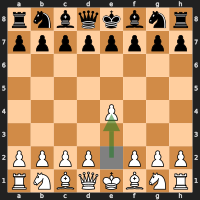

'Player Black to Board Agent: Actually, Player White, as I am Player Black, you should be the one to start the game. How about we stick to the classic and you make the first move with e2 to e4?'

"Board Agent to Player Black: illegal uci: 'e2e4' in rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1"

"Player Black to Board Agent: Apologies for the confusion, Player White. You're right. Your move e2 to e4 is indeed a classic opening. Now, I'll respond with e7 to e5. Let's have a good game."

'Board Agent to Player Black: e7e5'

"Player Black to Player White: Apologies for the confusion, Player White. You're right. Your move e2 to e4 is indeed a classic opening. Now, I'll respond with e7 to e5. Let's have a good game."

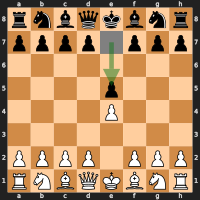

"Player White to Board Agent: Nice counter, Player Black. I see you're not new to this game. Now, I'll move my knight from g1 to f3. Your move."

'Board Agent to Player White: g1f3'

"Player White to Player Black: Nice counter, Player Black. I see you're not new to this game. Now, I'll move my knight from g1 to f3. Your move."

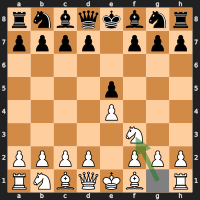

"Player Black to Board Agent: Indeed, Player White, I've had my fair share of games. Now, I'll move my knight from g8 to f6. It's your turn. I hope you're ready for a challenge."

'Board Agent to Player Black: g8f6'

"Player Black to Player White: Indeed, Player White, I've had my fair share of games. Now, I'll move my knight from g8 to f6. It's your turn. I hope you're ready for a challenge."

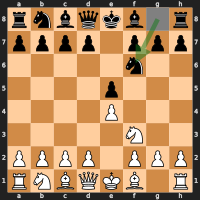

"Player White to Board Agent: I'm always ready for a challenge, Player Black. Now, I'll move my bishop from f1 to c4. I'm excited to see your next move."

'Board Agent to Player White: f1c4'

"Player White to Player Black: I'm always ready for a challenge, Player Black. Now, I'll move my bishop from f1 to c4. I'm excited to see your next move."

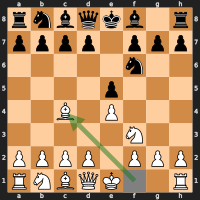

"Player Black to Board Agent: Thank you for your move, Player White. I'll move my bishop from f8 to c5. I'm looking forward to seeing what you do next."

'Board Agent to Player Black: f8c5'

"Player Black to Player White: Thank you for your move, Player White. I'll move my bishop from f8 to c5. I'm looking forward to seeing what you do next."

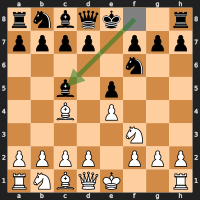

"Player White to Board Agent: I see you're setting up your pieces nicely, Player Black. Now, I'll move my queen from d1 to e2. I hope you're enjoying the game as much as I am."

'Board Agent to Player White: d1e2'

"Player White to Player Black: I see you're setting up your pieces nicely, Player Black. Now, I'll move my queen from d1 to e2. I hope you're enjoying the game as much as I am."

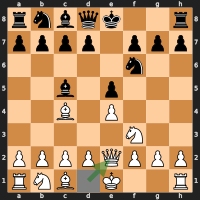

"Player Black to Board Agent: Indeed, Player White, I am enjoying the game. Now, I'll castle kingside. Your move. Let's see how this game unfolds."

'Board Agent to Player Black: e8g8'

"Player Black to Player White: Indeed, Player White, I am enjoying the game. Now, I'll castle kingside. Your move. Let's see how this game unfolds."

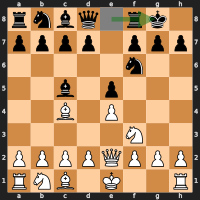

"Player White to Board Agent: Thank you for the update, Player Black. I see you've castled, a wise move. Now, I'll castle kingside as well. Your move. I'm intrigued to see what you have planned."

'Board Agent to Player White: e1g1'

"Player White to Player Black: Thank you for the update, Player Black. I see you've castled, a wise move. Now, I'll castle kingside as well. Your move. I'm intrigued to see what you have planned."

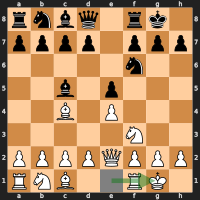

"Player Black to Board Agent: Thank you, Player White. I see we're both playing it safe. I'll now move my pawn from d7 to d6. Your move. It's always a pleasure to engage in such a strategic game."

'Board Agent to Player Black: d7d6'

"Player Black to Player White: Thank you, Player White. I see we're both playing it safe. I'll now move my pawn from d7 to d6. Your move. It's always a pleasure to engage in such a strategic game."

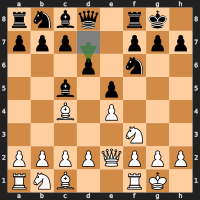

In [12]:
stream.run()